<a href="https://colab.research.google.com/github/tngjody/bt4221-airfare-booking/blob/main/BT4221_Group_20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BT4221 Group 20: Optimising Airfare Booking with Predictive Analytics

Group Members:

Gong Yongjia A0286144X

Jody Tng Jin Zi A0238195W

Wu Shuhan A0266501L

Zhou Jingchu Jeslyn A0275993H




# Data Loading & Exploration

In [2]:
from pyspark.sql import SparkSession

# Initialize Spark Sesison
spark = SparkSession.builder.appName("FlightPrices").getOrCreate()

# Load Dataset
flight_df = spark.read.csv("flight.csv", header=True, inferSchema=True)

# Show a sample (5 rows) of the data
flight_df.show(5, truncate=False)

# Display schema
flight_df.printSchema()

# Total Count
flight_df.count()

+--------------------------------+----------+----------+---------------+------------------+-------------+--------------+-----------+--------------+------------+---------+--------+---------+--------------+-------------------+---------------------------------+------------------------------------------------------------+-------------------------------+------------------------------------------------------------+--------------------------+----------------------------+-------------------+-------------------+------------------------------+-------------------------+----------------+-----------------+
|legId                           |searchDate|flightDate|startingAirport|destinationAirport|fareBasisCode|travelDuration|elapsedDays|isBasicEconomy|isRefundable|isNonStop|baseFare|totalFare|seatsRemaining|totalTravelDistance|segmentsDepartureTimeEpochSeconds|segmentsDepartureTimeRaw                                    |segmentsArrivalTimeEpochSeconds|segmentsArrivalTimeRaw                          

2000000

# Data Cleaning & Pre-processing

In [3]:
# Remove rows with null values

# Drop duplicates
flight_df = flight_df.dropDuplicates()

# Final Count
flight_df.count()

print(f"Number of rows after dropping duplicates: {flight_df.count()}")
print(f"Number of columns: {len(flight_df.columns)}")

Number of rows after dropping duplicates: 2000000
Number of columns: 27


In [4]:
from pyspark.sql.functions import col, sum, isnan
from pyspark.sql.types import NumericType

# Build expressions to count missing values (null and NaN for numeric columns; null only otherwise)
missing_exprs = []
for field in flight_df.schema.fields:
    if isinstance(field.dataType, NumericType):
        # For numeric columns, count both nulls and NaNs
        expr = sum((col(field.name).isNull() | isnan(col(field.name))).cast("int")).alias(field.name)
    else:
        # For non-numeric columns, count only nulls
        expr = sum(col(field.name).isNull().cast("int")).alias(field.name)
    missing_exprs.append(expr)

# Compute missing values count per column
missing_counts = flight_df.select(*missing_exprs)
missing_counts.show()

+-----+----------+----------+---------------+------------------+-------------+--------------+-----------+--------------+------------+---------+--------+---------+--------------+-------------------+---------------------------------+------------------------+-------------------------------+----------------------+--------------------------+----------------------------+-------------------+-------------------+----------------------------+-------------------------+----------------+-----------------+
|legId|searchDate|flightDate|startingAirport|destinationAirport|fareBasisCode|travelDuration|elapsedDays|isBasicEconomy|isRefundable|isNonStop|baseFare|totalFare|seatsRemaining|totalTravelDistance|segmentsDepartureTimeEpochSeconds|segmentsDepartureTimeRaw|segmentsArrivalTimeEpochSeconds|segmentsArrivalTimeRaw|segmentsArrivalAirportCode|segmentsDepartureAirportCode|segmentsAirlineName|segmentsAirlineCode|segmentsEquipmentDescription|segmentsDurationInSeconds|segmentsDistance|segmentsCabinCode|
+---

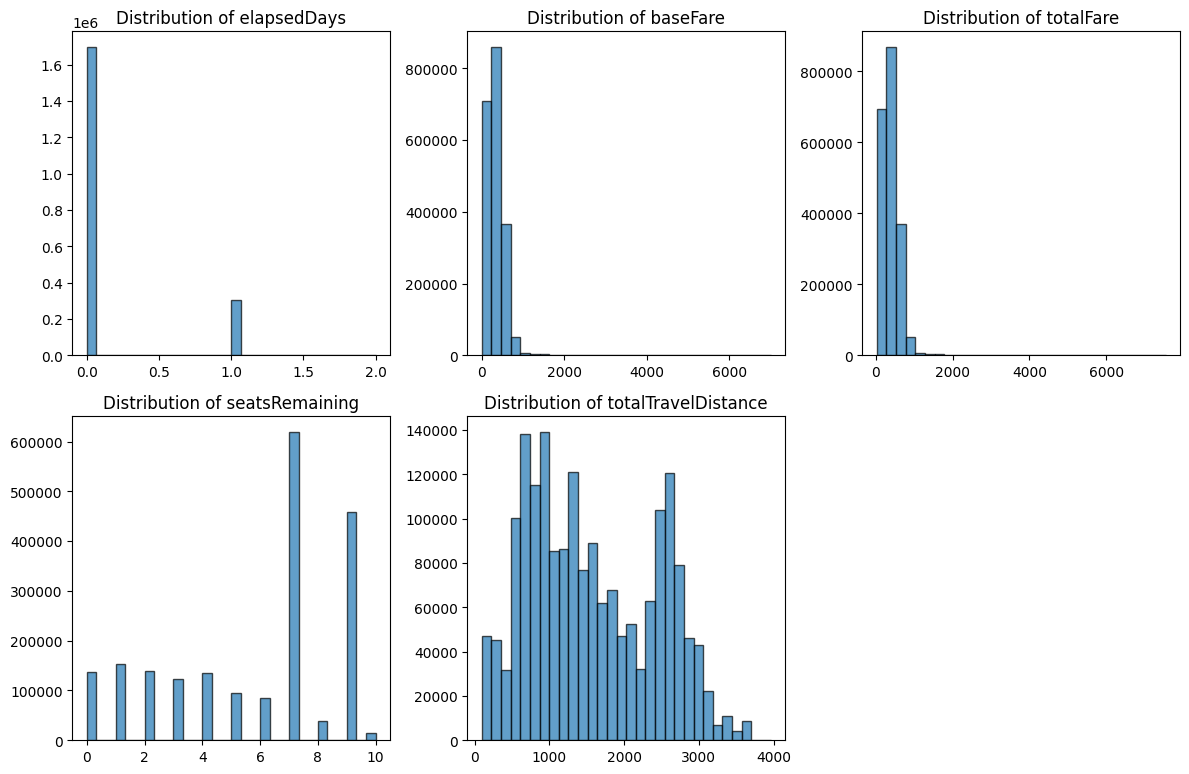

In [5]:
import matplotlib.pyplot as plt

# Select only numeric columns
numeric_cols = [col for col, dtype in flight_df.dtypes if dtype in ('int', 'double')]

# Plot histograms directly from PySpark DataFrame
plt.figure(figsize=(12, 8))

for i, col_name in enumerate(numeric_cols, 1):
    plt.subplot(2, 3, i)  # Creates a grid of subplots

    # Collect data from PySpark DataFrame
    data = flight_df.select(col_name).rdd.flatMap(lambda x: x).filter(lambda x: x is not None).collect()

    # Plot histogram
    plt.hist(data, bins=30, alpha=0.7, edgecolor='black')
    plt.title(f"Distribution of {col_name}")

plt.tight_layout()
plt.show()

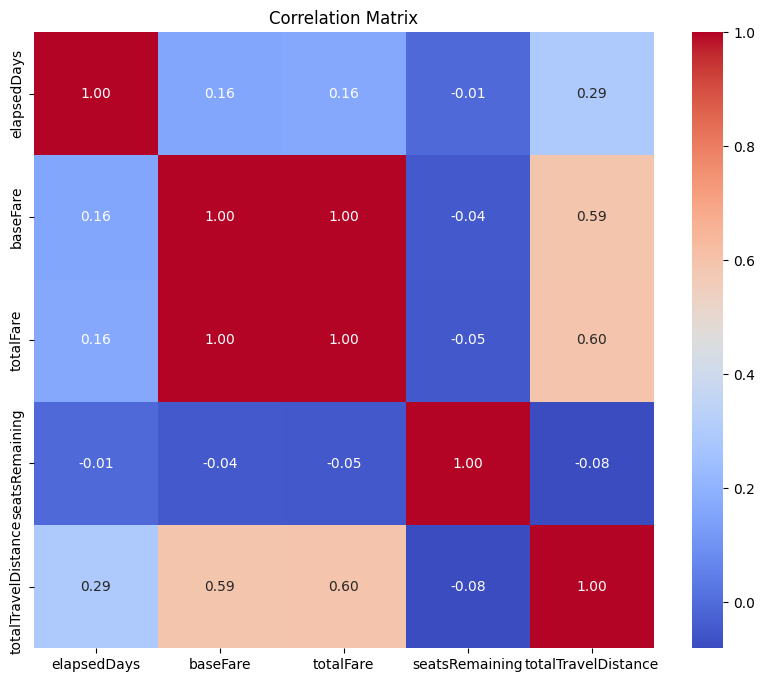

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col

# Select only numeric columns and convert to double
numeric_cols = [col for col, dtype in flight_df.dtypes if dtype in ('int', 'double')]

# Convert integer columns to double (required for Correlation.corr)
for col_name in numeric_cols:
    flight_df = flight_df.withColumn(col_name, col(col_name).cast("double"))

# Assemble numeric columns into a feature vector
vector_col = "features"
assembler = VectorAssembler(inputCols=numeric_cols, outputCol=vector_col)
df_vector = assembler.transform(flight_df).select(vector_col)

# Compute correlation matrix
correlation_matrix = Correlation.corr(df_vector, vector_col).head()[0].toArray()

# Plot heatmap directly
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f",
            xticklabels=numeric_cols, yticklabels=numeric_cols)

plt.title("Correlation Matrix")
plt.show()

In [14]:
from pyspark.ml.feature import StringIndexer
from pyspark.sql import functions as F

# Create a new column 'airport_pair' by combining 'startingAirport' and 'destinationAirport'
flight_df = flight_df.withColumn("airport_pair", F.concat_ws("_", "startingAirport", "destinationAirport"))

# Index the 'airport_pair' column to convert it into a numeric column
indexer = StringIndexer(inputCol="airport_pair", outputCol="airport_pair_index")
indexed_df = indexer.fit(flight_df).transform(flight_df)

# Group by 'airport_pair' and calculate the average and standard deviation of 'totalTravelDistance'
airport_distance_stats_df = indexed_df.groupBy("airport_pair").agg(
    F.avg("totalTravelDistance").alias("avg_totalTravelDistance"),
    F.stddev("totalTravelDistance").alias("stddev_totalTravelDistance")
)

# Show the result
airport_distance_stats_df.show(truncate=False)

from pyspark.sql.functions import col

# Calculate the Coefficient of Variation (CV) for each airport_pair
airport_distance_stats_with_cv_df = airport_distance_stats_df.withColumn(
    "cv_totalTravelDistance",
    (col("stddev_totalTravelDistance") / col("avg_totalTravelDistance")) * 100
)

# Show the result with the CV column
airport_distance_stats_with_cv_df.show(truncate=False)


+------------+-----------------------+--------------------------+
|airport_pair|avg_totalTravelDistance|stddev_totalTravelDistance|
+------------+-----------------------+--------------------------+
|SFO_OAK     |845.8357754519506      |231.39154163742202        |
|JFK_DTW     |719.0025806451613      |264.6701807261453         |
|SFO_LAX     |455.07911001236096     |286.5561374392203         |
|LGA_LAX     |2604.5250622759586     |279.2937530828567         |
|ATL_ORD     |939.9411039161271      |392.0352468500932         |
|DEN_JFK     |1997.7305378304466     |392.1459632726835         |
|JFK_DEN     |1940.4280626011873     |373.49655764594746        |
|ATL_MIA     |1145.132917174178      |593.9042253310238         |
|ORD_CLT     |933.9325               |318.0496528900427         |
|DTW_DEN     |1498.6819909502262     |401.5764270552886         |
|JFK_CLT     |700.1699484604203      |267.20429352110756        |
|OAK_CLT     |2699.562077443147      |258.596586554082          |
|BOS_ATL  

+------------+-----------------------+--------------------------+----------------------+
|airport_pair|avg_totalTravelDistance|stddev_totalTravelDistance|cv_totalTravelDistance|
+------------+-----------------------+--------------------------+----------------------+
|SFO_OAK     |845.8357754519506      |231.39154163742202        |27.356556479747375    |
|JFK_DTW     |719.0025806451613      |264.6701807261453         |36.810741414677075    |
|SFO_LAX     |455.07911001236096     |286.5561374392203         |62.96842266203711     |
|LGA_LAX     |2604.5250622759586     |279.2937530828567         |10.723404321507909    |
|ATL_ORD     |939.9411039161271      |392.0352468500932         |41.708490586988454    |
|DEN_JFK     |1997.7305378304466     |392.1459632726835         |19.629572449673695    |
|JFK_DEN     |1940.4280626011873     |373.49655764594746        |19.248152757864517    |
|ATL_MIA     |1145.132917174178      |593.9042253310238         |51.86334410826209     |
|ORD_CLT     |933.932

In [29]:
from pyspark.sql import functions as F

# 1. Split the `segmentsAirlineCode` by '||' and count the number of elements (segments)
flight_with_segments = flight_df.withColumn(
    "num_segments",
    F.size(F.split("segmentsAirlineCode", "\|\|"))  # Split the '||' and count the number of elements
)

# 2. Group by 'airport_pair' and 'num_segments' to calculate the average and standard deviation of 'totalTravelDistance'
airport_segments_stats_df = flight_with_segments.groupBy("airport_pair", "num_segments").agg(
    F.avg("totalTravelDistance").alias("avg_totalTravelDistance"),  # Calculate average of totalTravelDistance
    F.stddev("totalTravelDistance").alias("stddev_totalTravelDistance")  # Calculate standard deviation of totalTravelDistance
)

# 3. Calculate the Coefficient of Variation (CV) by dividing the standard deviation by the mean and multiplying by 100
airport_segments_stats_with_cv_df = airport_segments_stats_df.withColumn(
    "cv_totalTravelDistance",
    (F.col("stddev_totalTravelDistance") / F.col("avg_totalTravelDistance")) * 100  # Calculate CV
)

# Show the result with CV column
airport_segments_stats_with_cv_df.show(truncate=False)



<>:6: SyntaxWarning: invalid escape sequence '\|'
<>:6: SyntaxWarning: invalid escape sequence '\|'
/var/folders/m6/f548v7p52jj_fnkl9bm320bw0000gn/T/ipykernel_17408/3819764505.py:6: SyntaxWarning: invalid escape sequence '\|'
  F.size(F.split("segmentsAirlineCode", "\|\|"))  # Split the '||' and count the number of elements


+------------+------------+-----------------------+--------------------------+----------------------+
|airport_pair|num_segments|avg_totalTravelDistance|stddev_totalTravelDistance|cv_totalTravelDistance|
+------------+------------+-----------------------+--------------------------+----------------------+
|SFO_IAD     |2           |2655.7685891748006     |157.23700043580612        |5.920583633556068     |
|BOS_LGA     |2           |754.7771975630983      |309.3143592908858         |40.98088287372084     |
|LGA_CLT     |3           |1315.3823529411766     |143.77532528756532        |10.930306687335868    |
|DFW_ORD     |3           |1377.75                |69.0495540108038          |5.011762221796683     |
|PHL_CLT     |2           |889.1019819126419      |284.3249429797872         |31.978889797112537    |
|DFW_BOS     |2           |1630.9132104454686     |143.28343759164318        |8.785472867223062     |
|DFW_IAD     |2           |1377.673287496817      |142.78809687161117        |10.3

In [30]:

# Group by 'airport_pair' and check the distinct count of 'num_segments' for each pair
airport_segments_consistency_df = flight_with_segments.groupBy("airport_pair").agg(
    F.countDistinct("num_segments").alias("distinct_num_segments_count")
)

# Filter out airport pairs that have more than one distinct value for 'num_segments'
inconsistent_airport_pairs_df = airport_segments_consistency_df.filter(
    F.col("distinct_num_segments_count") > 1
)

# Show inconsistent airport pairs
inconsistent_airport_pairs_df.show(truncate=False)

+------------+---------------------------+
|airport_pair|distinct_num_segments_count|
+------------+---------------------------+
|SFO_OAK     |2                          |
|JFK_DTW     |3                          |
|SFO_LAX     |3                          |
|ATL_ORD     |4                          |
|LGA_LAX     |3                          |
|ORD_CLT     |4                          |
|DTW_DEN     |3                          |
|DEN_JFK     |3                          |
|JFK_DEN     |3                          |
|ATL_MIA     |3                          |
|JFK_CLT     |3                          |
|OAK_CLT     |2                          |
|BOS_ATL     |3                          |
|DEN_SFO     |3                          |
|LAX_DFW     |3                          |
|ATL_SFO     |3                          |
|DFW_DEN     |3                          |
|DFW_ORD     |4                          |
|DEN_MIA     |3                          |
|ATL_EWR     |3                          |
+----------